
In this notebook, we will try the process of implementing RNN with Keras in order to classify text sentences.

I.   **Firstly**, we'll import useful packages.

II.   **Then**, we'll load the data and create a word embedding matrix using Glove.

III.  **We'll try a simple RNN model** and then we will evaluate its performances.

IV. Finally, we'll use techniques to increase our model's accuracy.

## Mounting Google Drive locally
Mount the Google Driver into the Google Colab Driver.


In [1]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.6 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# I. Import all useful packages.

In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import json
import tensorflow.keras
import tensorflow
import datetime
from tensorflow.keras import backend as K
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, concatenate, add
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model, load_model
import tensorflow_addons as tfa

from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plot
import seaborn as sn

Copy the dataset from Google Drive into Colab

In [4]:
file_path = '/content/gdrive/MyDrive/Colab Notebooks/DSP304x_Asm2_resources/train.csv'
!cp "{file_path}" .

In [5]:
file_path_1 = '/content/gdrive/MyDrive/Colab Notebooks/DSP304x_Asm2_resources/glove.6B.50d.txt'
!cp "{file_path_1}" .


# II. Load the data.

## About dataset.
An invalid question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is invalid:

* Has a non-neutral tone.
* Is disparaging or inflammatory.
* Isn't grounded in reality.
* Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

The data includes the question that was asked, and whether it was identified as invalid (target = 1). 

**Load the dataset.**
* Load the data from CSV file.
* Remove all the rows with NA values.
* Split the data into 3 set: Training set, validation set and test set (0.9/0.05/0.05, random_seed = 9) with a same ratio of data number beween each class.
* Print out these dataset's description.




In [6]:
def load_data(data_link):
    '''
    input: data link.
    output:
        train_set, validation_set and test_set(0.9/0.05/0.05) without NA values.
    '''
    dataset = pd.read_csv(data_link)
    dataset.rename(columns = {'target':'label'}, inplace=True)
    dataset = dataset.dropna(axis=0, subset=['question_text'])

    X_train, X_test, y_train, y_test = train_test_split(
        dataset[['qid', 'question_text']], dataset['label'], 
        test_size=0.1, random_state=9)
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_test, y_test, test_size=0.5, random_state=9)
    #train, validation, test = np.split(dataset.sample(frac=1, random_state=9), 
                                        #[int(.9*len(dataset)), int(.95*len(dataset))]) # split dataset to 3 set

    train = pd.concat([X_train, y_train], axis=1, ignore_index=True) 
    train.rename(columns={0: "qid", 1: "question_text", 2: "label"}, inplace=True)
    validation = pd.concat([X_val, y_val], axis=1, ignore_index=True)
    validation.rename(columns={0: "qid", 1: "question_text", 2: "label"}, inplace=True)
    test = pd.concat([X_test, y_test], axis=1, ignore_index=True)   
    test.rename(columns={0: "qid", 1: "question_text", 2: "label"}, inplace=True)                                
    return train, validation, test

train_set, validation_set, test_set = load_data('train.csv')
print(train_set['label'].describe())
print(validation_set['label'].describe())
print(test_set['label'].describe())


count    1.175509e+06
mean     6.185150e-02
std      2.408858e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: label, dtype: float64
count    65306.000000
mean         0.062644
std          0.242323
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64
count    65307.000000
mean         0.061433
std          0.240125
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


Text(0.5, 1.0, 'label_count')

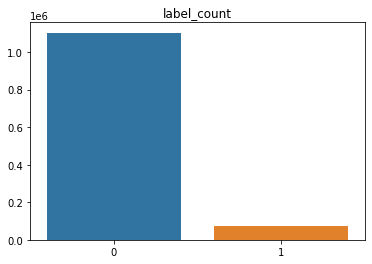

In [7]:
values, counts = np.unique(train_set['label'], return_counts=True)
sn.barplot(x=values, y=counts)
plot.title('label_count')

# Encoding text data.
Let declare some fundamental parameters first:

In [37]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 50 # max number of words in a question to use


Encode the dataset using Tokenizer and one-hot encoding vector.
* Encode the text (question_text column) by turning each question text into a list of word indexes using [Tokenizer](https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do) with **max_features** and all the text sentences from the training and the validation set. 
* Turn each list of word indexes into an equal length - **max_len** (with truncation or padding as needed) using [pad_sequences](https://keras.io/preprocessing/sequence/).
* Encode the label (label column) using [to_categorical](https://keras.io/utils/) function on Keras.

In [38]:
def encoding_textdata(train_set, validation_set, test_set, max_features, max_len):
    '''
    Input:
    - Train/validation/test dataset.
    - max_features, max_len.
    Output:
    - X train/validation/test, y train/validation/test.
    - Tokenizer.
    '''
    tokenizer = Tokenizer(num_words=max_features)
    text_strings = train_set['question_text'].to_list() + validation_set['question_text'].to_list()
    tokenizer.fit_on_texts(text_strings)
    # encode strings to list of word indexes 
    X_tr = tokenizer.texts_to_sequences(train_set['question_text'].to_list())
    X_va = tokenizer.texts_to_sequences(validation_set['question_text'].to_list())
    X_te = tokenizer.texts_to_sequences(test_set['question_text'].to_list())
    # pad sequences
    X_tr = pad_sequences(X_tr, maxlen=max_len)
    X_va = pad_sequences(X_va, maxlen=max_len)
    X_te = pad_sequences(X_te, maxlen=max_len)
    # encode the label to one-hot vector
    y_tr = to_categorical(np.array(train_set['label'].to_list()))
    y_va = to_categorical(np.array(validation_set['label'].to_list()))
    y_te = to_categorical(np.array(test_set['label'].to_list()))
    return (X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer



In [9]:
(X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer = encoding_textdata(train_set, validation_set, test_set, max_features, max_len)

Create word embedding matrix.
* Firstly, write a function to [load the GloVe dictionary.](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)
* Then, create a word embedding matrix using GloVe dictionary with these parameters:
    - Word embedding matrix shape: (Number of word, embed_size).
    - Embed size: 50.
    - Number of words: The minimum of (max_features, len(word_index)), while word_index is the dictionary of word which contains in tokenizer.
    - If a word occurs in GloVe dictionary, we should take its initialization value as in GloVe dictionary. Otherwise, take a normal random value with mean and std as mean and std of GloVe dictionary value.
    



In [39]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
def get_GloVe_dict(GloVe_link):
    '''
    input: GloVe link.
    output: GloVe dictionary.
    '''
    GloVe_dict = {}
    with open(GloVe_link, 'r') as file:
      for line in file:
        values = line.split()
        word, vector = get_coefs(values[0],values[1:])
        GloVe_dict[word] = vector
    return GloVe_dict
    


In [40]:
GloVe_link = 'glove.6B.50d.txt'
GloVe_dict = get_GloVe_dict(GloVe_link)

In [41]:
def create_embedding_matrix(GloVe_dict, tokenizer, max_features):
    '''
    input: GloVe dictionaray, tokenizer from training and validation dataset, number of max features.
    output: Word embedding matrix.
    '''
    word_index = tokenizer.get_config()['word_index']
    word_index = json.loads(word_index)
    word_index_keys = list(word_index.keys())

    GloVe_dict_keys = list(GloVe_dict.keys())
    GloVe_vectors = np.stack(list(GloVe_dict.values()))
    GloVe_dict_mean = np.mean(GloVe_vectors)
    GloVe_dict_std = np.std(GloVe_vectors)

    number_of_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(GloVe_dict_mean, GloVe_dict_std, size=(number_of_words, embed_size))

    for i in range(number_of_words):
      if word_index_keys[i] in GloVe_dict_keys:
        embedding_matrix[i] = GloVe_dict.get(word_index_keys[i])

    print('embedding_matrix shape:', embedding_matrix.shape)

    return embedding_matrix



In [42]:
embedding_matrix = create_embedding_matrix(GloVe_dict, tokenizer, max_features)

embedding_matrix shape: (20000, 50)


III. Modelling
There are some steps we need to finish:
Build the model.

Compile the model.

Train / fit the data to the model.

Evaluate the model on the testing set.

## Build the model
We can build an easy model composed of different layers such as:
* [Embedding](https://keras.io/layers/embeddings/) layer with max_features, embed_size and embedding_matrix.
* [Bidirectional LSTM layer](https://keras.io/examples/imdb_bidirectional_lstm/) with number of hidden state = 50, dropout_rate = 0.1 and recurrent_dropout_rate = 0.1.
* GlobalMaxPool1D.
* Dense with number of unit = 50, activation = 'relu'.
* Dropout with rate = 0.1.
* Final dense with number of unit = number of class, activation = 'sigmoid'.

In [12]:
def create_model(max_len, max_features, embed_size):
    '''
    input: max_len, max_features, embed_size
    output: model.
    '''
    inputs = Input(shape=(None,))
    embedding = Embedding(input_dim=max_features, output_dim=embed_size, 
                          embeddings_initializer=tensorflow.keras.initializers.Constant(embedding_matrix))(inputs)
    bidirectional_rnn = Bidirectional(LSTM(units=50, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))(embedding)
    global_max_pool_1d = GlobalMaxPool1D()(bidirectional_rnn)
    dense = Dense(units=50, activation='relu')(global_max_pool_1d)
    dropout = Dropout(rate=0.1)(dense)
    outputs = Dense(units=2, activation='sigmoid')(dropout)
    model = Model(inputs=inputs, outputs=outputs)

    return model



In [15]:
model = create_model(max_len, max_features, embed_size)

Compile the model and setup the callback. Then print out the model summary.
* [Compile](https://keras.io/models/model/#compile) the model with Adam Optimizaer, lr = 1e-2, suitable loss for binary classification problem and ["F1-score"](https://github.com/tensorflow/addons/issues/825) as metric.
* Print out the model summary.

In [13]:
def optimize(model):
    '''
    Input: 
        Model.
    Return: 
        Complied model.
    '''
    ## TYPE YOUR CODE for task 8 here:
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-2), loss='binary_crossentropy', 
                  metrics=[tfa.metrics.F1Score(num_classes=2, average='micro', name='f1_score')])
    return model



In [17]:
model = optimize(model)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 50)          1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 100)         40400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102   

Setup callback.
* Create the [tensorboard callback](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to save the logs.
* Create the [checkpoint callback](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) to save the checkpoint with the best accuracy after each epoch.
* Create the [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau) callback with factor=0.3, patience=1 and "Validation F1-score" monitor.
* Create the [early stopping callback](https://keras.io/callbacks/#earlystopping) with patience=7, mode = 'max' and "Validation F1-score" monitor.



In [14]:
def callback_model(checkpoint_name, logs_name):
    '''
    Input: 
        Best checkpoint name, logs name.
    Return: 
        Callback list, which contains tensorboard callback and checkpoint callback.
    '''
    tf_board = TensorBoard(log_dir='/content/gdrive/MyDrive/Colab Notebooks/DSP304x_Asm2_resources/' + logs_name)
    check_point = ModelCheckpoint(filepath='/content/gdrive/MyDrive/Colab Notebooks/DSP304x_Asm2_resources/' + checkpoint_name,
                                                  monitor='f1_score', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.3, patience=1)
    early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=7)
    callbacks_list = [tf_board, check_point, reduce_lr, early_stopping]
    return callbacks_list

checkpoint_name = 'weights.best.hdf5'
logs_name = 'training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

Train the model.

* Train the model with 20 epochs with batch_size = 4096.
* Return the model with best-checkpoint weights.

*Hint*: Fit the model first, then reload the model (load_model function) with best-checkpoint weights.

In [19]:
def train_model(model, callbacks_list):
    '''
    Input: 
        Model and callback list,
    Return: 
        Model with best-checkpoint weights.
    '''
    model.fit(X_tr, y_tr, batch_size=4096, epochs=20, callbacks=[callbacks_list], validation_data=(X_va, y_va))

    model = load_model(filepath='/content/gdrive/MyDrive/Colab Notebooks/DSP304x_Asm2_resources/' + checkpoint_name)
    return model

model = train_model(model, callbacks_list)


Epoch 1/20
287/287 [==============================] - 208s 694ms/step - loss: 0.1380 - f1_score: 0.9481 - val_loss: 0.1148 - val_f1_score: 0.9549
Epoch 2/20
287/287 [==============================] - 195s 680ms/step - loss: 0.1091 - f1_score: 0.9563 - val_loss: 0.1139 - val_f1_score: 0.9530
Epoch 3/20
287/287 [==============================] - 196s 683ms/step - loss: 0.1015 - f1_score: 0.9589 - val_loss: 0.1107 - val_f1_score: 0.9563
Epoch 4/20
287/287 [==============================] - 193s 674ms/step - loss: 0.0915 - f1_score: 0.9630 - val_loss: 0.1146 - val_f1_score: 0.9564
Epoch 5/20
287/287 [==============================] - 195s 680ms/step - loss: 0.0862 - f1_score: 0.9652 - val_loss: 0.1168 - val_f1_score: 0.9554
Epoch 6/20
287/287 [==============================] - 193s 674ms/step - loss: 0.0844 - f1_score: 0.9662 - val_loss: 0.1175 - val_f1_score: 0.9554
Epoch 7/20
287/287 [==============================] - 194s 676ms/step - loss: 0.0837 - f1_score: 0.9664 - val_loss: 0.1177 -

In [20]:
model = load_model(filepath='/content/gdrive/MyDrive/Colab Notebooks/DSP304x_Asm2_resources/' + checkpoint_name)

Prediction on test set.

* Complete the get_prediction_classes function.
* Print out the precision, recall and F1 score.

In [15]:
def get_prediction_classes(model, X, y):
    '''
    Input: 
        Model and prediction dataset.
    Return: 
        Prediction list and groundtrurth list with predicted classes.
    '''
    predictions = model.predict(X)
    predictions = np.argmax(predictions, axis=1)
    map_value = lambda x: 0 if x == 1 else 1 # convert back 1-hot vector 
    groundtruths = np.array([map_value(x[0]) for x in y])

    return predictions, groundtruths


In [23]:
test_predictions, test_groundtruths = get_prediction_classes(model, X_te, y_te)
print(precision_score(test_groundtruths, test_predictions))
print(recall_score(test_groundtruths, test_predictions))
print(f1_score(test_groundtruths, test_predictions))

0.6805599745466115
0.5331505483549352
0.5979035639412998


Perform the predicted result on test set using confusion matrix. Remember to show the class name in the confusion matrix.

In [16]:
def plot_confusion_matrix(predictions, groundtruth, class_names):
    ## TYPE YOUR CODE for task 13 here:
    confusion_matrix = CM(groundtruth, predictions, normalize='true')
    ax = sn.heatmap(confusion_matrix, robust=True, 
               xticklabels=class_names, yticklabels=class_names, 
               vmin=confusion_matrix.min(), vmax=confusion_matrix.max(), annot=True, 
               cmap='viridis', fmt='.2%')
    cbar = ax.collections[0].colorbar # add color bar 
    cbar.ax.tick_params(labelsize=15) # customized ticks for color bar 
    sn.set(font_scale=1)
    plot.title('Confusion matrix', fontsize=15)
    plot.show()


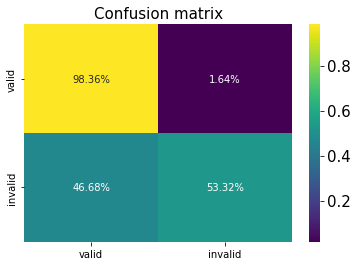

In [25]:
class_names = ['valid', 'invalid']
plot_confusion_matrix(test_predictions, test_groundtruths, class_names)

Model finetuning - fine tune the model using some of these approachs:
* Increase max epochs, change batch size.
* Replace LSTM by GRU units and check if it changes anything.
* Add another layer of LSTM/GRU, see if things improve.
* Play around with Dense layers (add/# units/etc).
* Find preprocessing rules you could add to improve the quality of the data.
* Find another GloVe dictionary.
Requirement: The F1 score should increase by 2-3%.

In [17]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek


nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english')) 
wordnet_lemmatizer = WordNetLemmatizer()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [18]:
# lower text
train_set['question_text_clean'] = train_set['question_text'].apply(lambda x: x.lower())
validation_set['question_text_clean'] = validation_set['question_text'].apply(lambda x: x.lower())
test_set['question_text_clean'] = test_set['question_text'].apply(lambda x: x.lower())

In [19]:
# remove number
train_set['question_text_clean'] = train_set['question_text_clean'].apply(lambda x: re.sub(r'[0-9]', '', x))
validation_set['question_text_clean'] = validation_set['question_text_clean'].apply(lambda x: re.sub(r'[0-9]', '', x))
test_set['question_text_clean'] = test_set['question_text_clean'].apply(lambda x: re.sub(r'[0-9]', '', x))

In [20]:
def remove_stop_words(text):
  text = ' '.join([word for word in text.split() if word not in stop_words])
  return text


train_set['question_text_clean'] = train_set['question_text_clean'].apply(remove_stop_words)
validation_set['question_text_clean'] = validation_set['question_text_clean'].apply(remove_stop_words)
test_set['question_text_clean'] = test_set['question_text_clean'].apply(remove_stop_words)

In [21]:
def lemmatize(text):
  sentence = []    
  for word in word_tokenize(text):
    word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
    word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
    word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
    word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
    sentence.append(word4)
  text = ' '.join(sentence)
  return text


train_set['question_text_clean'] = train_set['question_text_clean'].apply(lemmatize)
validation_set['question_text_clean'] = validation_set['question_text_clean'].apply(lemmatize)
test_set['question_text_clean'] = test_set['question_text_clean'].apply(lemmatize)

In [49]:
# after preprocessing
train_set[train_set['label'] == 1].head()

,qid,question_text,label,question_text_clean
166599,208bb67e05636662d4d5,What should a person do if his sister says I w...,1,person sister say want dick walk away ?
1004017,c4c57ea29e3564aa552f,Where have all the good guys gone?,1,good guy go ?
123837,183e2b2fedafce343920,Who is the best randwa in Nagpur?,1,best randwa nagpur ?
147988,1cf146b9afcc432d3818,Why do some people don't accept that they are ...,1,"people accept gay , even come mind might gay ?"
373582,493c7515a631baa58054,How much money from Putin can I get for creati...,1,"much money putin get create 'anti-fracking ' ,..."


In [91]:
# resampling data
oversampler = RandomOverSampler(sampling_strategy=0.15, random_state=0) 
undersampler = RandomUnderSampler(sampling_strategy=0.3, random_state=0)

X_tr, y_tr = oversampler.fit_resample(train_set[['qid','question_text_clean']], train_set['label'])
X_tr, y_tr = undersampler.fit_resample(X_tr, y_tr)

train_set_resamp = pd.DataFrame(np.concatenate((X_tr, y_tr.reshape((-1,1))), axis=1), columns=['qid', 'question_text_clean', 'label'])
train_set_resamp.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


,qid,question_text_clean,label
0,97f14a88fa4a7f96fc40,interaction heredity environment relation psyc...,0
1,1de96a346078b05837ad,inspire book `` black white '' paul volponi ?,0
2,cd9d7c68fe5ab6f71f5f,"much resemble parent , term look behaviour ?",0
3,be8f3089a5078f575f0d,intellect subversive love intimacy ?,0
4,b9cc8631385e44721312,sexist thing ever do ?,0


Text(0.5, 1.0, 'label_count')

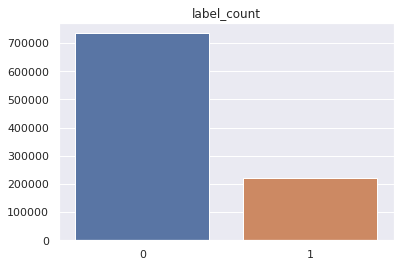

In [92]:
values, counts = np.unique(train_set_resamp['label'], return_counts=True)
sn.barplot(x=values, y=counts)
plot.title('label_count')

In [82]:
def encoding_textdata(train_set, validation_set, test_set, max_features, max_len):
    '''
    Input:
    - Train/validation/test dataset.
    - max_features, max_len.
    Output:
    - X train/validation/test, y train/validation/test.
    - Tokenizer.
    '''
    tokenizer = Tokenizer(num_words=max_features)
    text_strings = train_set['question_text_clean'].to_list() + validation_set['question_text_clean'].to_list()
    tokenizer.fit_on_texts(text_strings)
    # encode strings to list of word indexes 
    X_tr = tokenizer.texts_to_sequences(train_set['question_text_clean'].to_list())
    X_va = tokenizer.texts_to_sequences(validation_set['question_text_clean'].to_list())
    X_te = tokenizer.texts_to_sequences(test_set['question_text_clean'].to_list())
    # pad sequences
    X_tr = pad_sequences(X_tr, maxlen=max_len)
    X_va = pad_sequences(X_va, maxlen=max_len)
    X_te = pad_sequences(X_te, maxlen=max_len)
    # encode the label to one-hot vector
    y_tr = to_categorical(np.array(train_set['label'].to_list()))
    y_va = to_categorical(np.array(validation_set['label'].to_list()))
    y_te = to_categorical(np.array(test_set['label'].to_list()))
    return (X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer

In [83]:
(X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer = encoding_textdata(train_set_resamp, validation_set, test_set, max_features, max_len)

In [84]:
def create_model(max_len, max_features, embed_size):

    inputs = Input(shape=(max_len,))
    embedding = Embedding(input_dim=max_features, output_dim=embed_size, 
                          weights=[embedding_matrix])(inputs) 
    x = Bidirectional(GRU(units=64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding) 
    x = Bidirectional(GRU(units=64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.1)(x)
    outputs = Dense(units=2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    return model


model = create_model(max_len, max_features, embed_size)

In [85]:
model = optimize(model)
print(model.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 50, 50)            1000000   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 50, 128)           44544     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 50, 128)           74496     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0   

In [86]:
checkpoint_name = 'new_weights.best.hdf5'
logs_name = 'new_training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

In [87]:
def train_model(model, callbacks_list):
 
    model.fit(X_tr, y_tr, batch_size=4096, epochs=20, callbacks=[callbacks_list], validation_data=(X_va, y_va))

    model = load_model(filepath='/content/gdrive/MyDrive/Colab Notebooks/DSP304x_Asm2_resources/' + checkpoint_name)
    return model

model = train_model(model, callbacks_list)

Epoch 1/20
176/176 [==============================] - 245s 1s/step - loss: 0.2870 - f1_score: 0.8761 - val_loss: 0.1264 - val_f1_score: 0.9468
Epoch 2/20
176/176 [==============================] - 223s 1s/step - loss: 0.2119 - f1_score: 0.9138 - val_loss: 0.1499 - val_f1_score: 0.9320
Epoch 3/20
176/176 [==============================] - 220s 1s/step - loss: 0.1878 - f1_score: 0.9237 - val_loss: 0.1489 - val_f1_score: 0.9329
Epoch 4/20
176/176 [==============================] - 224s 1s/step - loss: 0.1617 - f1_score: 0.9349 - val_loss: 0.1522 - val_f1_score: 0.9368
Epoch 5/20
176/176 [==============================] - 223s 1s/step - loss: 0.1496 - f1_score: 0.9403 - val_loss: 0.1937 - val_f1_score: 0.9186
Epoch 6/20
176/176 [==============================] - 223s 1s/step - loss: 0.1477 - f1_score: 0.9410 - val_loss: 0.1811 - val_f1_score: 0.9271
Epoch 7/20
176/176 [==============================] - 223s 1s/step - loss: 0.1420 - f1_score: 0.9435 - val_loss: 0.1799 - val_f1_score: 0.9283

In [88]:
model = load_model(filepath='/content/gdrive/MyDrive/Colab Notebooks/DSP304x_Asm2_resources/' + checkpoint_name)

In [89]:
test_predictions, test_groundtruths = get_prediction_classes(model, X_te, y_te)
print(precision_score(test_groundtruths, test_predictions))
print(recall_score(test_groundtruths, test_predictions))
print(f1_score(test_groundtruths, test_predictions))

0.5693918467364669
0.6370887337986042
0.601341018703682


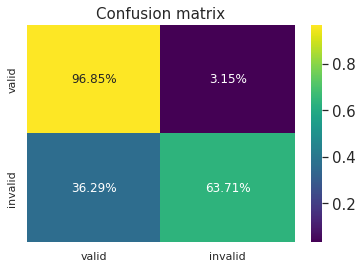

In [90]:
class_names = ['valid', 'invalid']
plot_confusion_matrix(test_predictions, test_groundtruths, class_names)